In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import grangercausalitytests
import pickle
from sklearn.model_selection import train_test_split
import re


from FRUFS import FRUFS
import matplotlib.pyplot as plt
import optuna
import joblib, gc
import lightgbm as lgb
import seaborn as sns

from sklearn.datasets import make_regression
from scipy.stats import pearsonr
from tqdm.notebook import trange, tqdm
from FRUFS import FRUFS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sigfig import round


/home/apoletaev/miniconda3/envs/test1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Progress bar: 100%|██████████| 6/6 [00:01<00:00,  3.61it/s]


MAE Train = 0.014638058519668927; MAE_test = 0.009127986142365381
MAE Train = 0.013381556425768975; MAE_test = 0.008447042152557666
MAE Train = 0.012736302434714733; MAE_test = 0.008019601597127087
MAE Train = 0.012633909052122794; MAE_test = 0.00948604869013598
MAE Train = 0.01252251349594043; MAE_test = 0.008821522126447741
MAE Train = 0.012477853250732347; MAE_test = 0.00867497484252242


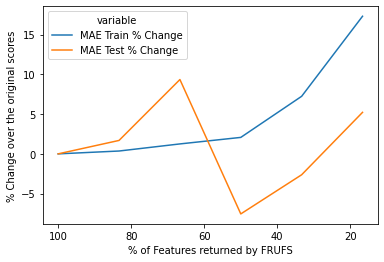

Stop


In [6]:

# Unpickling the data
infile = open("Sun_Model_Data",'rb')
Model_Data = pickle.load(infile)
infile.close()

# Reading in the data
sun_x_train = Model_Data.train_x
sun_y_train = Model_Data.train_y
sun_y_test = Model_Data.test_y
sun_x_test = Model_Data.test_x
sun_MAE_train = Model_Data.MAE["train"]
sun_MAE_test = Model_Data.MAE["test"]
sun_fin_model = Model_Data.fin_model

sun_model_params = list(sun_fin_model.params.index)

total_n_features = len(list(sun_x_train.columns))
# Defining FRUFS model with k=maximum features
model_frufs_generated = FRUFS(
            model_r=lgb.LGBMRegressor(random_state=42),
            k=total_n_features,
            n_jobs = -1
            #categorical_features = ["#Buys", "# Hold", "# Sell", "Total Rec"]
        )
# fit_transform returns data ranked in the order of importance
pruned_df = model_frufs_generated.fit_transform(sun_x_train)

FRUFS_Loop = {"MAE Train":[], "MAE Test":[], "Feature %":[]}

for n in list(range(1, total_n_features+1)):
    pruned_df_cut =  pruned_df.iloc[:,:n]
    # Training the model on the features selected by FRUFS
    # Check whether the Sun Model has a constant or not
    if "const" in sun_model_params:
        frufs_model = AutoReg(sun_y_train, lags=0, exog=pruned_df_cut).fit()
    else:
        frufs_model = AutoReg(sun_y_train, lags=0, exog=pruned_df_cut, trend="n").fit()

    # Calculating MAE train (.sqeeze is reuired when sun_y is saved as a DF and not series)
    MAE_train = np.nanmean(abs(frufs_model.predict() - sun_y_train.squeeze()))

    # Saving names of the features selected by FRUFS in a list
    frufs_features = list(pruned_df_cut.columns)

    # Defining test dataset with only features selected by FRUFS 
    frufs_x_test = sun_x_test[frufs_features]

    # Defining first and last out-of-sample indices to predict
    first_oos_ind = len(sun_y_train)
    last_oos_ind = first_oos_ind + len(sun_y_test) - 1

    # Predicting the oos ys with the test data
    y_pred_out_frufs = frufs_model.predict(start=first_oos_ind, end=last_oos_ind, exog_oos=frufs_x_test)
    # Resetting index to make MAE_test calcuation possible
    y_pred_out_frufs.reset_index(drop=True, inplace=True)
    # Calculating MAE Test
    MAE_test = np.nanmean(abs(y_pred_out_frufs - sun_y_test.squeeze()))

    print(f"MAE Train = {MAE_train}; MAE_test = {MAE_test}")
    # Feature_pc = round(n/total_n_features, sigfigs=3)

    FRUFS_Loop["MAE Train"].append(MAE_train)
    FRUFS_Loop["MAE Test"].append(MAE_test)
    FRUFS_Loop["Feature %"].append((n/total_n_features)*100)

FRUFS_Loop["MAE Train % Change"] = ((FRUFS_Loop["MAE Train"]/sun_MAE_train) - 1)*100
FRUFS_Loop["MAE Test % Change"] = ((FRUFS_Loop["MAE Test"]/sun_MAE_test) - 1)*100
FRUFS_Loop = pd.DataFrame.from_dict(FRUFS_Loop)
FRUFS_Long = pd.melt(FRUFS_Loop, ['Feature %'])

FRUFS_Vis = FRUFS_Long.loc[FRUFS_Long['variable'].isin(["MAE Train % Change", "MAE Test % Change"])]

ax = sns.lineplot(x='Feature %', y='value', hue='variable', 
             data=FRUFS_Vis)

ax.invert_xaxis()

ax.set(xlabel='% of Features returned by FRUFS', ylabel='% Change over the original scores')


plt.show()

print("Stop")



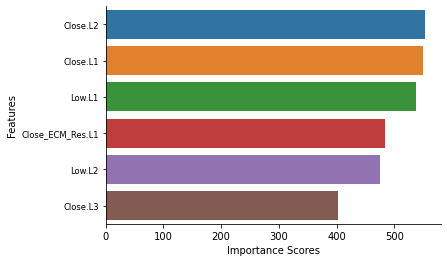

In [7]:
model_frufs_generated.feature_importance()